### Project 

__Problem Statement__    
The EndSARS movement originated in 2017 and revitalized in 2020. It is a campaign that started on twitter using the hashtag #ENDSARS to protest against police brutality in Nigeria alongside calls for the disbanding of th Specia; Anti-Robbery Squad (SARS). As at now, more than 28 million tweets bearing the hashtag #ENDSARS have accumulated on twitter.

1. Scrape as many tweets pertaining to the hashtag 


1. Perform EDA on the tweets
2. Perform sentiment analysis on the tweets
3. How has the sentiment changed over time?

#### Methodology:  

1. Scrape the data with the hashtag #ENDSARS from twitter using __snscrape__
2. Perform EDA on the tweets using python-pandas and seaborn(majorly) for visualization
3. Preprocess the tweet, cleaning the data.
4. Perform sentiment analysis using __TextBlob__
5. Visualize patterns in sentiment-type

In [1]:
%pip install snscrape
%pip install textblob
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.




In [3]:
# Importing necessary dependencies

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import snscrape.modules.twitter as sntwitter
import numpy as np
import itertools
from sklearn.metrics import accuracy_score
from textblob import TextBlob
import re
import nltk
#nltk.download('all')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
import string
import os
warnings.filterwarnings(action="ignore")

Using Snscrape to scrape the tweets

In [4]:
# Setting variables to be used below
maxTweets = 20000

# Creating list to append tweet data to
tweets_list = []

# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('hashtag:ENDSARS').get_items()):
    if i>maxTweets:
        break
    tweets_list.append([tweet.date, tweet.id, tweet.content])

In [5]:
# Creating a dataframe from the tweets list above
df = pd.DataFrame(tweets_list, columns=['Datetime', 'Tweet Id', 'Text'])

# Display first 5 entries from dataframe
df.head()

,Datetime,Tweet Id,Text
0,2022-10-07 06:03:08+00:00,1578264644686430208,@Aremoguccy @SavvyRinu @YeleSowore @segalink @...
1,2022-10-07 06:00:34+00:00,1578263998440812544,@Aremoguccy @SavvyRinu @YeleSowore @segalink @...
2,2022-10-03 19:09:43+00:00,1577013044495847424,"Subsequently, the hashtag #ENDSARS started to ..."
3,2022-10-03 16:20:28+00:00,1576970450382782466,"... Subsequently, the hashtag #ENDSARS started..."
4,2022-10-03 13:28:12+00:00,1576927096881917952,"Subsequently, the hashtag #ENDSARS started to ..."


In [7]:
df.tail()

,Datetime,Tweet Id,Text
11148,2017-12-02 17:27:49+00:00,937010426503680001,Please Y’all should use the hashtag #ENDSARS o...
11149,2017-12-02 17:21:20+00:00,937008795640791042,Angry Nigerian Youths Shut Down Twitter With T...
11150,2017-12-02 16:50:06+00:00,937000937012580352,Dear @bukolasaraki are you following this hash...
11151,2017-12-02 16:37:55+00:00,936997871815143424,He contacted the tuberculosis and had to be ru...
11152,2017-12-02 16:33:29+00:00,936996754045751296,@iam_Davido please tweet the hashtag #EndSARS ...


### EDA

In [8]:
df1 = df.copy()

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11153 entries, 0 to 11152
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   Datetime  11153 non-null  datetime64[ns, UTC]
 1   Tweet Id  11153 non-null  int64              
 2   Text      11153 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 261.5+ KB


__A total of 11,153 tweets with the ENDSARS hashtag on twitter was extracted__

In [10]:
df1.isnull().sum()

Datetime    0
Tweet Id    0
Text        0
dtype: int64

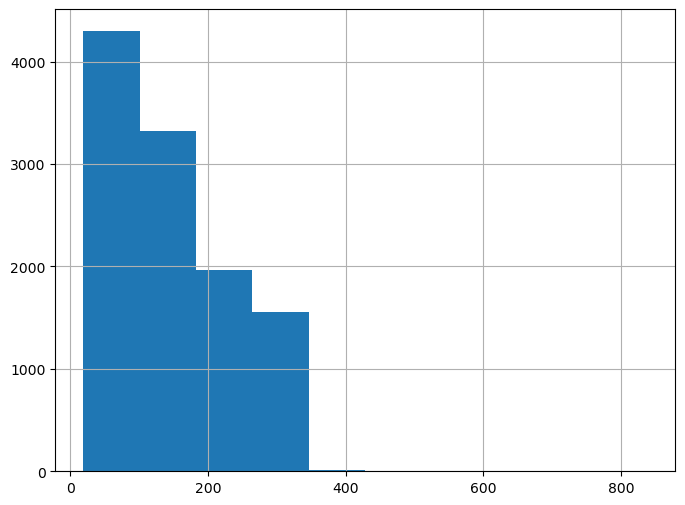

In [11]:
df1['Text'].str.len().hist(figsize=(8, 6))
plt.show()

In [12]:
#Extracting datetime features

df1['Datetime'] = pd.to_datetime(df1['Datetime'])
datetime_col = ['Datetime']
def extract_date_info(df, col,):
    for feat in col:
        df[feat +'_day'] = df[feat].dt.day
        df[feat +'_month'] = df[feat].dt.month
        df[feat+'_WeekDay'] = df[feat].dt.weekday
        df[feat+'_Quarter'] = df[feat].dt.quarter
        df[feat+'_year'] = df[feat].dt.year
        df['Tweet time'] = df[feat].dt.time
        df['monthname'] = df[feat].dt.month_name()
        df['dayname'] = df[feat].dt.day_name()
    df.drop(columns=col,axis=1,inplace=True)

extract_date_info(df1, datetime_col)    

In [14]:
df1['month_year'] = df1['monthname'].astype(str) + '_' + df1['Datetime_year'].astype(str)
df1['day_month_year'] = df1['Datetime_day'].astype(str) + '_' + df1['monthname'].astype(str) + '_' + df1['Datetime_year'].astype(str)

In [15]:
df1.columns

Index(['Tweet Id', 'Text', 'Datetime_day', 'Datetime_month',
       'Datetime_WeekDay', 'Datetime_Quarter', 'Datetime_year', 'Tweet time',
       'monthname', 'dayname', 'month_year', 'day_month_year'],
      dtype='object')

In [16]:
df1['month_year'].value_counts()

October_2020      10161
December_2020       186
November_2020       153
December_2017       146
February_2021        95
June_2018            35
January_2021         34
October_2021         33
April_2019           24
May_2021             24
September_2020       23
June_2021            22
June_2022            19
January_2022         13
August_2018          13
September_2019       12
April_2021           11
March_2021           11
August_2019          10
December_2019        10
May_2020             10
October_2022         10
May_2022              8
July_2020             7
November_2021         7
July_2018             7
February_2022         6
June_2020             6
July_2022             5
October_2019          5
February_2020         5
January_2018          5
August_2022           4
February_2018         4
December_2021         3
March_2022            3
January_2019          3
January_2020          2
March_2018            2
September_2021        2
May_2018              1
October_2018    

In [17]:
df1['month_count'] = df1['month_year'].map(df1['month_year'].value_counts().to_dict())
df1['day_count'] = df1['day_month_year'].map(df1['day_month_year'].value_counts().to_dict())

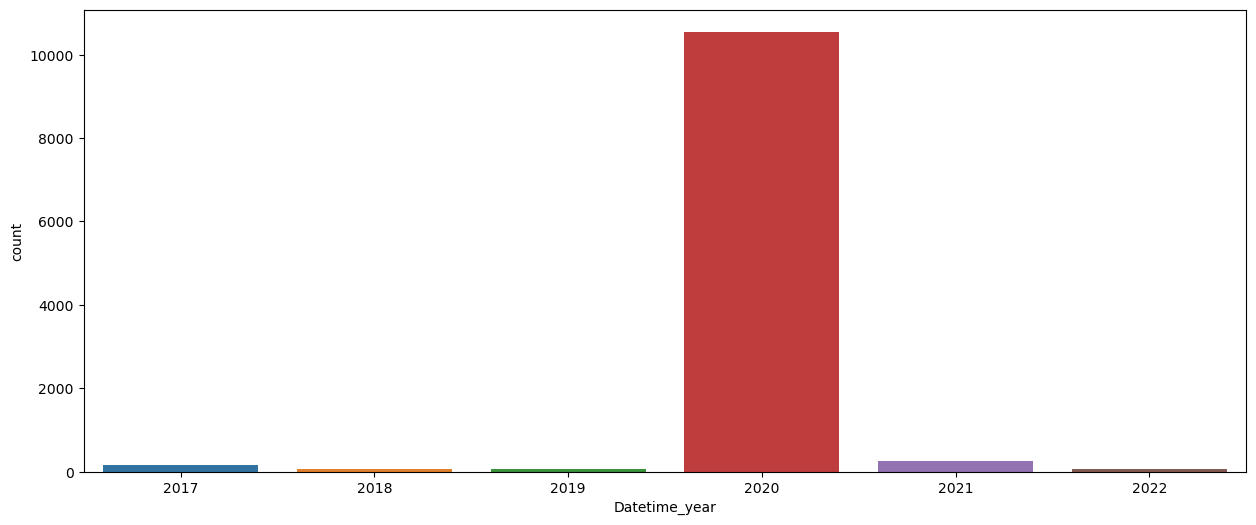

In [18]:
# To check the volume of tweet per year
plt.figure(figsize=(15, 6))
sns.countplot(x='Datetime_year', data=df1)
plt.show()

The tweets on ENDSARS drastically increased in 2020 with over 11,000 number of tweets.

In [19]:
# %number of tweets per year

df1.groupby('Datetime_year')['Tweet Id'].count() * 100 /len(df1)

Datetime_year
2017     1.309065
2018     0.627634
2019     0.600735
2020    94.647180
2021     2.187752
2022     0.627634
Name: Tweet Id, dtype: float64

Over 94% of ENDSARS tweet occured in 2020

In [20]:
# %number of tweets per month and year

(df1.groupby(['month_count', 'month_year'])['Tweet Id'].count() * 100 /len(df1)).sort_values(ascending=False)[:5]

month_count  month_year   
10161        October_2020     91.105532
186          December_2020     1.667713
153          November_2020     1.371828
146          December_2017     1.309065
95           February_2021     0.851789
Name: Tweet Id, dtype: float64

Over 91% of ENDSARS tweet occured in October, 2020

In [21]:
# %number of tweets per day_month_year

(df1.groupby(['day_count', 'day_month_year'])['Tweet Id'].count() * 100 /len(df1)).sort_values(ascending=False)[:5]

day_count  day_month_year 
1977       11_October_2020    17.726172
1079       16_October_2020     9.674527
946        10_October_2020     8.482023
889        17_October_2020     7.970950
877        9_October_2020      7.863355
Name: Tweet Id, dtype: float64

We had the highest number of ENDSARS tweet on the 11th of October, 2020.

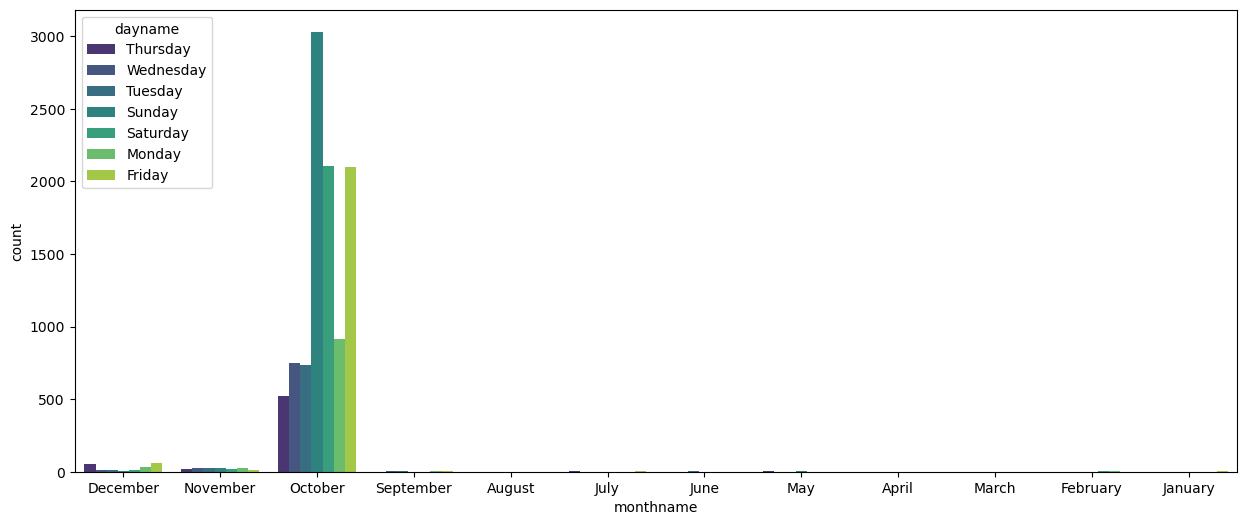

In [22]:
plt.figure(figsize=(15, 6))
sns.countplot(x='monthname', hue='dayname', data=df1[df1['Datetime_year']==2020], palette='viridis')
plt.show()

In 2020, the Month of October had more number of ENDSARS tweet than any other month.

Surprisingly, more number of ENDSARS tweet were tweeted on Sundays than on any other day of the week during the month of October.

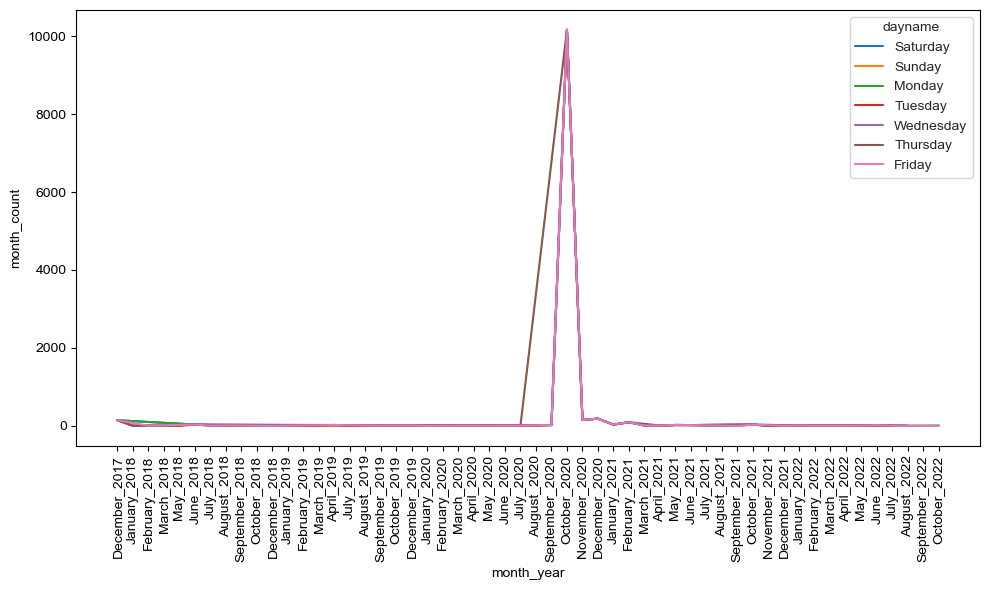

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('whitegrid')
sns.lineplot(x = 'month_year', y = 'month_count', data=df1[::-1], hue='dayname')
plt.xticks(rotation=90)
plt.tight_layout()

The trend of the ENDSARS tweet from the left (2017) to the right (2022).  
Tweets about the ENDSARS began increasing sometime in July-2020, it reached its peak in October, and finally went almost completely unmentioned around January 2021.

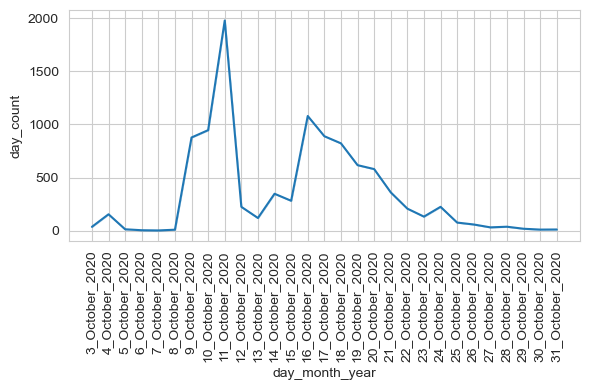

In [24]:
df2 = df1[::-1] # We want to rearrange the tweet from 2017 to 2022
plt.figure(figsize=(6, 4))
sns.lineplot(x='day_month_year', y='day_count', data=df2[(df2['Datetime_year']==2020) & (df2['monthname']=='October')])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

The trend of ENDSARS tweet in the month of October, 2020

### Building a WordCloud

In [25]:
def W_Cloud(data):
    text = " ".join(word for word in data['Text'])
    print(f"There are {len(text)} words in the combination of all words")  
    wordcloud = WordCloud(max_font_size=60, max_words=500, background_color="black").generate(text)
    plt.figure(figsize=(15, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

There are 1640875 words in the combination of all words


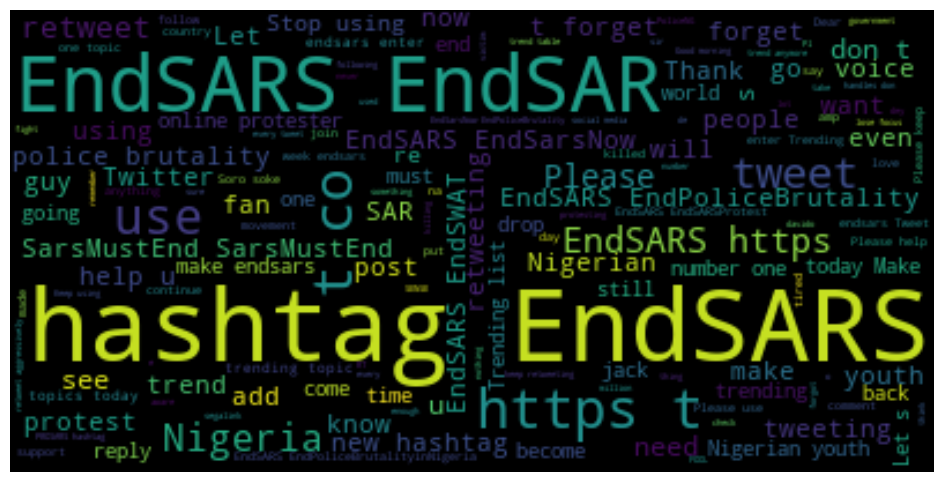

In [26]:
W_Cloud(df1)

### Sentiment Analysis

#### Cleaning the tweets : Data Preprocessing

In [27]:
def preprocess_tweet(tweet):
    # Convert to lower case
    tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    stopWord = stopwords.words('english')
    filtered_words = [w for w in tweet_tokens if not w in stopWord]
    ps = PorterStemmer()
    stemmed_words = [ps.stem(w) for w in filtered_words]
    
    return " ".join(filtered_words)


In [28]:
df1['Text'] = df1['Text'].apply(preprocess_tweet)

In [29]:
df1.loc[0, 'Text']

'man coined hashtag Endsars 2012 means founder'

### Creating Polarity and Sentiment_Type Feature Using TextBlob

In [30]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

In [31]:
df1['Polarity'] = df1['Text'].apply(get_polarity)

In [32]:
df1['Sentiment_Type'] = ''

df1.loc[df1.Polarity>0, 'Sentiment_Type'] = 'Positive'

df1.loc[df1.Polarity==0, 'Sentiment_Type'] = 'Neutral'

df1.loc[df1.Polarity<0, 'Sentiment_Type'] = 'Negative'

In [33]:
df1[['Text', 'Sentiment_Type']]

,Text,Sentiment_Type
0,man coined hashtag Endsars 2012 means founder,Neutral
1,man coined hashtag Endsars 2012 means founder ...,Neutral
2,Subsequently hashtag ENDSARS started garner mo...,Positive
3,Subsequently hashtag ENDSARS started garner mo...,Positive
4,Subsequently hashtag ENDSARS started garner mo...,Positive
...,...,...
11148,Please Y ’ use hashtag ENDSARS POLICEREFORM cc...,Neutral
11149,Angry Nigerian Youths Shut Down Twitter With T...,Negative
11150,Dear following hashtag EndSARS Seems youre sen...,Negative
11151,He contacted tuberculosis rushed hospital Stay...,Negative


<AxesSubplot:title={'center':'Sentiment Analysis'}>

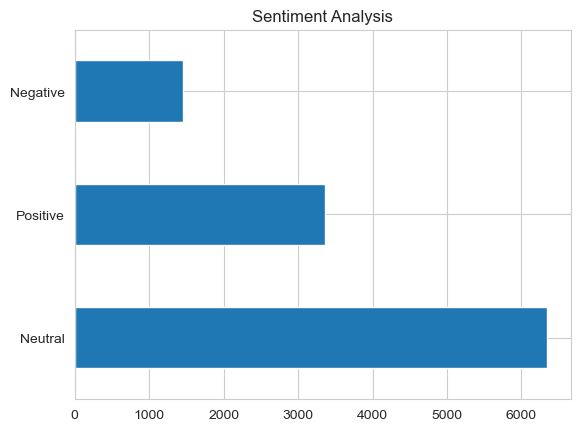

In [34]:
df1.Sentiment_Type.value_counts().plot(kind='barh', title='Sentiment Analysis')

### Building a WordCloud capturing the tweets with respect to the Sentiment Types

In [35]:
def Sentiment_analysis(Sentiments):
    text = " ".join(word for word in df1[df1.Sentiment_Type==Sentiments]['Text'] if 'hashtag'
                   not in word and 'EndSARS' not in word and 'Hashtag' not in word and
                   'FOOL' not in word and 'SLAVE' not in word and 'SWE' not in word)
    print(f"There are {len(text)} words in the combination of all words\
    in " + Sentiments + " sentiments")  
    wordcloud = WordCloud(max_font_size=60, max_words=1000, background_color="white").generate(text)
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

There are 582 words in the combination of all words    in Positive sentiments


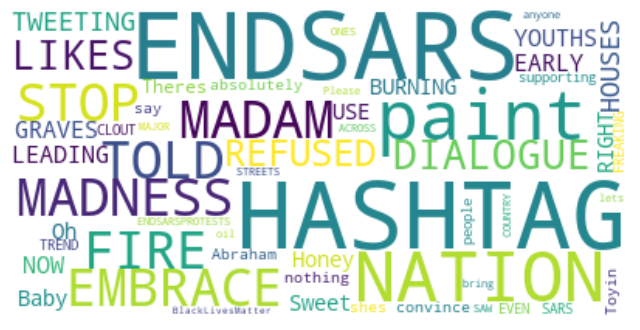

In [36]:
Sentiment_analysis('Positive')

There are 1738 words in the combination of all words    in Negative sentiments


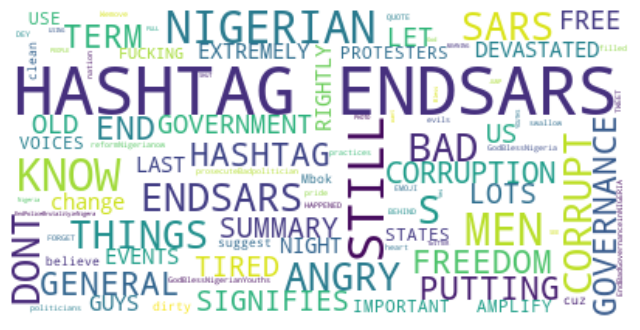

In [37]:
Sentiment_analysis('Negative')

There are 1756 words in the combination of all words    in Neutral sentiments


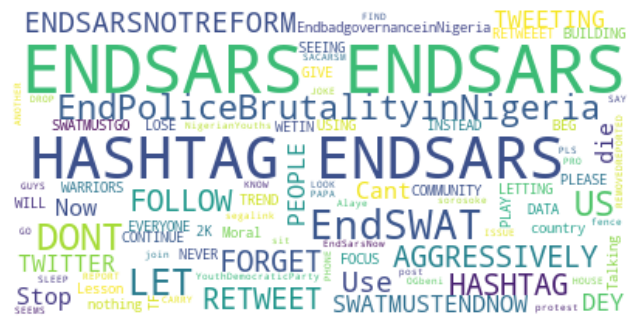

In [38]:
Sentiment_analysis('Neutral')

### Analyzing the changes in sentiment over time

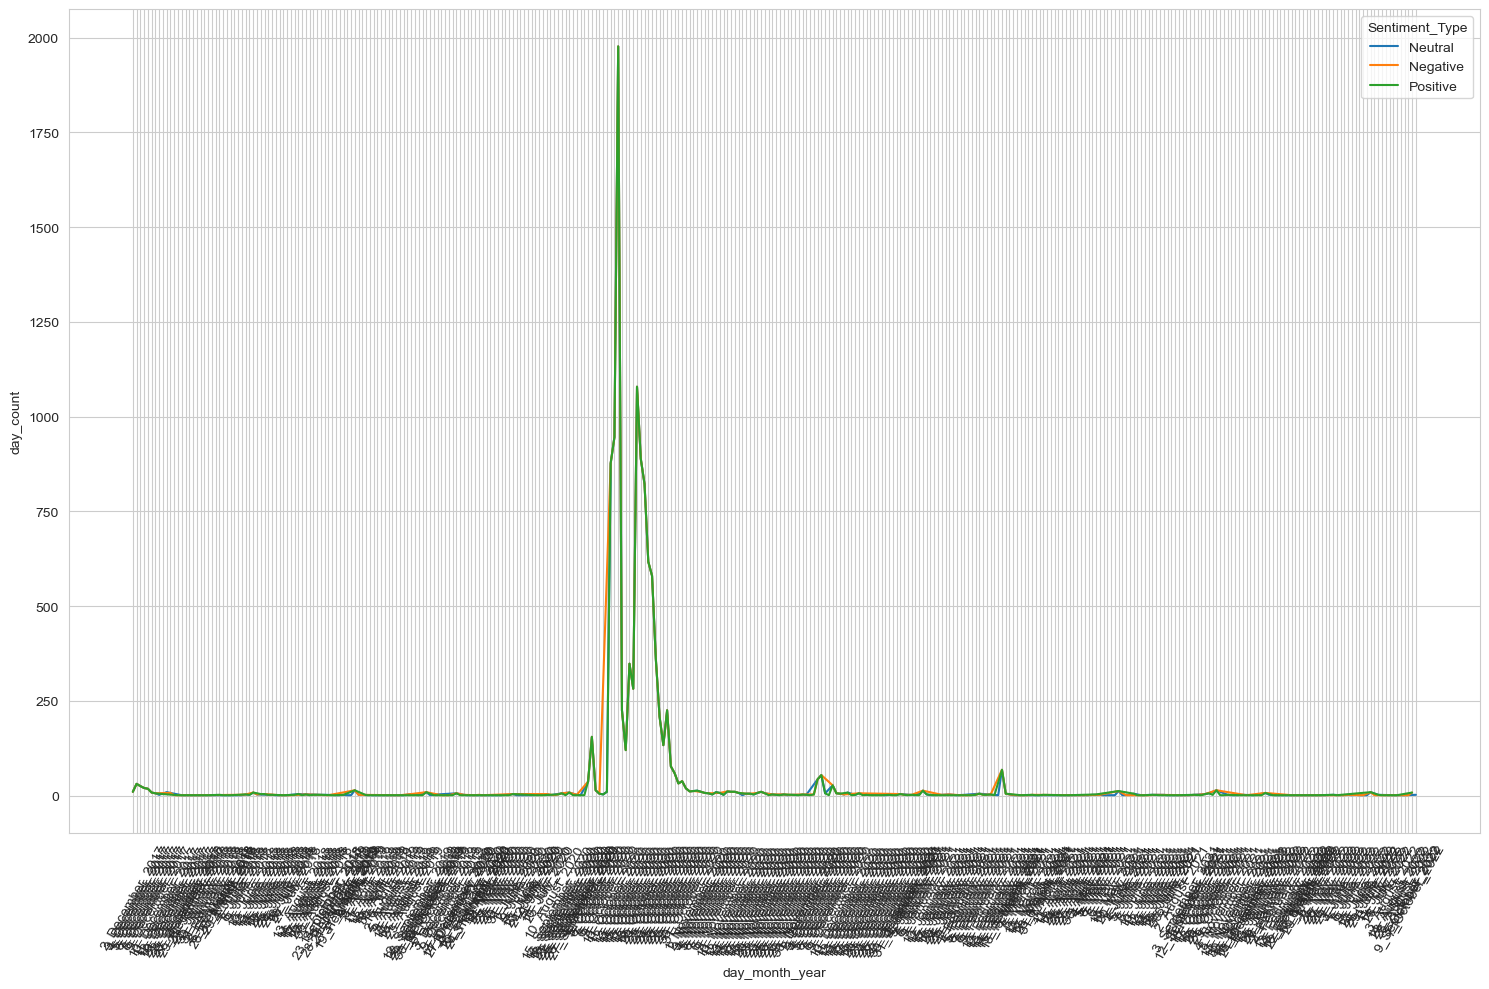

In [39]:
# Per DAY from year 2017 to 2022
plt.figure(figsize=(15, 10))
df2 = df1[::-1]
sns.lineplot(x='day_month_year', y='day_count', data=df2, hue='Sentiment_Type')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

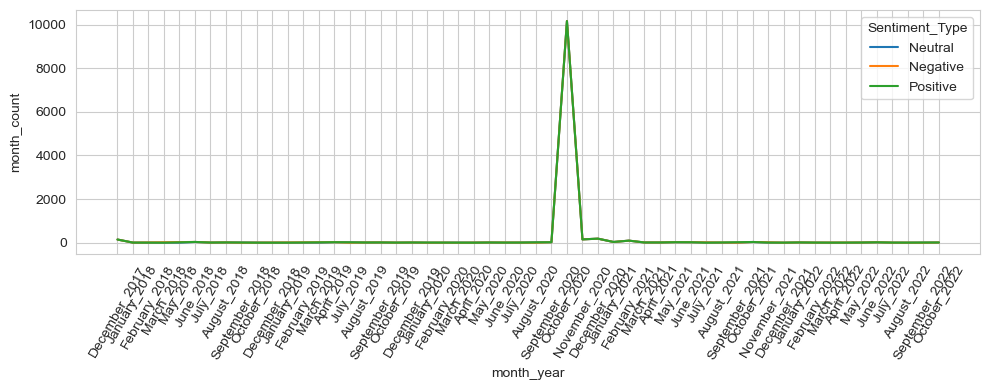

In [45]:
# Per Month from year 2017 to 2022
plt.figure(figsize=(10, 4))
df2 = df1[::-1]
sns.lineplot(x='month_year', y='month_count', data=df2, hue='Sentiment_Type')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

The trend shows a significant rise in negative tweets sometime between August 2020 to October 2020. It truly reflects the happenings touching the ENDSARS protest as it got really heated during that period, particularly in October. 

In [46]:
df2.to_csv('ENDSARS_tweet.csv')

We come to the end of this fun project.

We've been able to 
1. Extract tweets from twitter using Snscrape
2. Analyze the date time features surrounding these tweets
3. Preprocess the tweets
4. Carry out a sentiment Analysis of the tweet 
5. Build a word cloud to reflect these sentiments
6. Analyze the trend of the sentiment over time.